<h2>Virtual Imaging Techniques for 4D-STEM data</h2>
<strong>Jinseok Ryu, Ingyu Yoo<br></strong>
<strong>Electron Microscopy and Spectroscopy Lab.<br></strong>
<strong>Department of Materials Science and Engineering<br></strong>
<strong>Seoul National University<br><br></strong>

<strong>last update : 20221122</strong>

In [1]:
import numpy as np
import cv2

class sstem_python():
    
    def __init__(self, f_stack, ang_per_pixel, mrad_per_pixel):
        self.original_stack = f_stack
        self.original_shape = f_stack.shape
        self.original_pacbed = np.mean(self.original_stack, axis=(0, 1))
        self.ang_per_pixel = ang_per_pixel
        self.mrad_per_pixel = mrad_per_pixel
    
    def find_center(self):
        
        Y, X = np.indices(self.original_pacbed.shape)
        com_y = np.sum(self.original_pacbed * Y) / np.sum(self.original_pacbed)
        com_x = np.sum(self.original_pacbed * X) / np.sum(self.original_pacbed)
        self.ct = [com_y, com_x]        

    def disk_extract(self, buffer_size=0):
        grad = np.gradient(self.original_pacbed)
        grad_map = grad[0]**2 + grad[1] **2
        grad_map = grad_map / np.max(grad_map)
        
        max_ind = np.unravel_index(np.argmax(grad_map, axis=None), grad_map.shape)
        self.least_R = ((max_ind[0]-self.ct[0])**2 + (max_ind[1]-self.ct[1])**2)**(1/2)
        
        print("radius of the BF disk = %.2f mrad"%(self.mrad_per_pixel*self.least_R))
        
        self.cropped_size = np.around(self.least_R + buffer_size).astype(int)

        if self.cropped_size > self.ct[0] or self.cropped_size > self.ct[1]:
            self.cropped_size = np.min(self.ct).astype(int)
  
        print("radius of the RoI = %.2f mrad"%(self.mrad_per_pixel*self.cropped_size))
        
        h_si = np.floor(self.ct[0]-self.cropped_size).astype(int)
        h_fi = np.ceil(self.ct[0]+self.cropped_size).astype(int)
        w_si = np.floor(self.ct[1]-self.cropped_size).astype(int)
        w_fi = np.ceil(self.ct[1]+self.cropped_size).astype(int)
        
        self.c_ct = [self.cropped_size, self.cropped_size]
        
        self.c_stack = self.original_stack[:, :, h_si:h_fi, w_si:w_fi].copy()
        self.c_shape = self.c_stack.shape
        self.c_pacbed = np.mean(self.c_stack, axis=(0, 1))
        
    def virtual_stem(self, BF, ADF):
        self.BF_detector = radial_indices(self.original_pacbed.shape, BF, self.mrad_per_pixel, center=self.ct)
        self.BF_stem = np.sum(np.multiply(self.original_stack, self.BF_detector), axis=(2, 3))
        
        self.ADF_detector = radial_indices(self.original_pacbed.shape, ADF, self.mrad_per_pixel, center=self.ct)
        self.ADF_stem = np.sum(np.multiply(self.original_stack, self.ADF_detector), axis=(2, 3))
        
    def symmetry_evaluation(self, angle, also_mirror=False):
        """
        Krajnak, M. and J. Etheridge, Proc Natl Acad Sci U S A, 2020. 117(45): p. 27805-27810.
        """
        rotation_stack = []
        r_correl = np.zeros(self.original_shape[:2])
        m_correl = np.zeros(self.original_shape[:2])
        
        ri = radial_indices(self.c_pacbed.shape, [0, self.cropped_size], 1, center=self.c_ct)
        
        angle = angle * np.pi/180
        alpha, beta = np.cos(angle), np.sin(angle)
        M = np.array([[alpha, beta, (1-alpha)*self.c_ct[1]-beta*self.c_ct[0]], 
                      [-beta, alpha, beta*self.c_ct[1]+(1-alpha)*self.c_ct[0]]])
        
        for i in range(self.original_shape[0]):
            for j in range(self.original_shape[1]):
                tmp_dp = self.c_stack[i,j,:,:].copy()
                newdata = np.multiply(rotation(tmp_dp, M), ri)
                rotation_stack.append(newdata)
                r_correl[i,j] = correlation(tmp_dp/np.max(tmp_dp), newdata)
                
                if also_mirror:
                    m_correl[i, j] = mirror(newdata, self.c_ct)
        
        rotation_stack = np.asarray(rotation_stack).reshape(self.c_shape)
        
        return rotation_stack, r_correl, m_correl
    
    def DPC(self, correct_rotation=True, n_theta=100, hpass=0.0, lpass=0.0):
        """
        Hachtel, J.A., J.C. Idrobo, and M. Chi, Adv Struct Chem Imaging, 2018. 4(1): p. 10. (https://github.com/hachteja/GetDPC)
        Lazic, I., E.G.T. Bosch, and S. Lazar, Ultramicroscopy, 2016. 160: p. 265-280.
        Savitzky, B.H., et al., arXiv preprint arXiv:2003.09523, 2020. (https://github.com/py4dstem/py4DSTEM)
        """
        
        Y, X = np.indices(test.c_pacbed.shape)
        self.ysh = np.sum(test.c_stack * Y, axis=(2, 3)) / np.sum(test.c_stack, axis=(2, 3)) - test.c_ct[0]
        self.xsh = np.sum(test.c_stack * X, axis=(2, 3)) / np.sum(test.c_stack, axis=(2, 3)) - test.c_ct[1]
        
        self.ysh -= np.mean(self.ysh)
        self.xsh -= np.mean(self.xsh)
        
        if correct_rotation:
            theta = np.linspace(-np.pi/2, np.pi/2, n_theta, endpoint=True)
            self.div = []
            self.curl = []
            for t in theta:
                r_ysh = self.xsh * np.sin(t) + self.ysh * np.cos(t)
                r_xsh = self.xsh * np.cos(t) - self.ysh * np.sin(t)

                gyy, gyx = np.gradient(r_ysh)
                gxy, gxx = np.gradient(r_xsh)
                shift_divergence = gyy + gxx
                shift_curl = gyx - gxy

                self.div.append(np.mean(shift_divergence**2))
                self.curl.append(np.mean(shift_curl**2))
                
            self.c_theta = theta[np.argmin(self.curl)]
            tmp_ysh = self.xsh * np.sin(self.c_theta) + self.ysh * np.cos(self.c_theta)
            tmp_xsh = self.xsh * np.cos(self.c_theta) - self.ysh * np.sin(self.c_theta)
            
            self.ysh = tmp_ysh
            self.xsh = tmp_xsh
            
        self.E_mag = np.sqrt(self.ysh**2 + self.xsh**2)
        self.E_field_y = -self.ysh / np.max(self.E_mag)
        self.E_field_x = -self.xsh / np.max(self.E_mag)
        
        self.charge_density = np.gradient(self.E_field_y)[0] + np.gradient(self.E_field_x)[1]
        
        self.potential = get_icom(self.ysh, self.xsh, hpass, lpass)


def radial_indices(shape, radial_range, scale, center=None):
    y, x = np.indices(shape)
    if not center:
        center = np.array([(y.max()-y.min())/2.0, (x.max()-x.min())/2.0])
    
    r = np.hypot(y - center[0], x - center[1]) * scale
    ri = np.ones(r.shape)
    
    if len(np.unique(radial_range)) > 1:
        ri[np.where(r < radial_range[0])] = 0
        ri[np.where(r > radial_range[1])] = 0
        
    else:
        r = np.round(r)
        ri[np.where(r != round(radial_range[0]))] = 0
    
    return ri

def correlation(dat2d, newdata):
    # return correlation value
    dat1d = dat2d.flatten()
    new1d = newdata.flatten()
    correlation = np.correlate(dat1d, new1d)

    return correlation[0]

def rotation(data, RM):
    
    rotated = cv2.warpAffine(data, RM, data.shape)
                
    return rotated/np.max(rotated)

def mirror(data, center):
    #Input data : 2d # Return : Correlation value
    data1 = data[:, :int(center[1]-1)]
    data2 = np.flip(data, axis=1)[:, :int(center[1]-1)]
    value = correlation(data1, data2)        
    
    return value

def get_icom(ysh, xsh, hpass=0, lpass=0):
    
    FT_ysh = np.fft.fftshift(np.fft.fft2(np.fft.fftshift(ysh)))
    FT_xsh = np.fft.fftshift(np.fft.fft2(np.fft.fftshift(xsh)))
    
    ky = np.fft.fftshift(np.fft.fftfreq(FT_ysh.shape[0])).reshape(-1, 1)
    kx = np.fft.fftshift(np.fft.fftfreq(FT_xsh.shape[1])).reshape(1, -1)

    k2 = ky**2 + kx**2
    zero_ind = np.where(k2 == 0.0)
    k2[zero_ind] = 1.0

    FT_phase = (FT_ysh*ky + FT_xsh*kx) / (2*np.pi*1j*(hpass+k2+lpass*k2))
    FT_phase[zero_ind] = 0.0

    Iicom = np.real(np.fft.ifftshift(np.fft.ifft2(np.fft.ifftshift(FT_phase))))
    
    return Iicom

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def load_binary_4D_stack(img_adr, datatype, original_shape, final_shape, log_scale=False):
    stack = np.fromfile(img_adr, dtype=datatype)
    stack = stack.reshape(original_shape)
    if log_scale:
        stack = np.log(stack[:final_shape[0], :final_shape[1], :final_shape[2], :final_shape[3]])
    else:
        stack = stack[:final_shape[0], :final_shape[1], :final_shape[2], :final_shape[3]]
    return stack

In [2]:
import tifffile
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import tkinter.filedialog as tkf
import time
plt.rcParams['font.family'] = 'Times New Roman'

In [21]:
raw_adr = tkf.askopenfilename()
print(raw_adr)

datatype = "float32"
f_shape = [256, 256, 128, 128] # the shape of the 4D-STEM data [scanning_y, scanning_x, DP_y, DP_x]
o_shape = [f_shape[0], f_shape[1], f_shape[2]+2, f_shape[3]]

E:/github_repo/4DSTEM_processing/ptychography/practice/20221031/case_02/multislice_and_epie_02.tif


In [22]:
if raw_adr[-3:] == "raw":
    f_stack = load_binary_4D_stack(raw_adr, datatype, o_shape, f_shape, log_scale=False)
    f_stack = np.flip(f_stack, axis=2)
    f_stack = np.nan_to_num(f_stack)
    
elif raw_adr[-3:] == "tif" or raw_adr[:-4] == "tiff":
    f_stack = tifffile.imread(raw_adr)
    
else:
    print("The format of the file is not supported here")
    
print(f_stack.shape)
print(f_stack.min(), f_stack.max())
print(f_stack.mean())

f_stack = f_stack.clip(min=0.0)

(53, 55, 79, 81)
4.8529313e-16 0.0014275152
0.00015602751


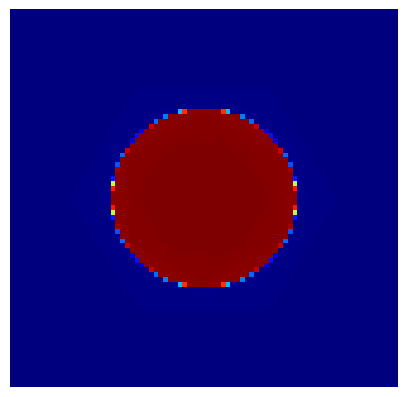

In [23]:
ang_per_pixel = 1
mrad_per_pixel = 1
test = sstem_python(f_stack, ang_per_pixel, mrad_per_pixel)

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(test.original_pacbed, cmap="jet")
ax.axis("off")
plt.show()

[38.99962438860853, 39.99843421419181]


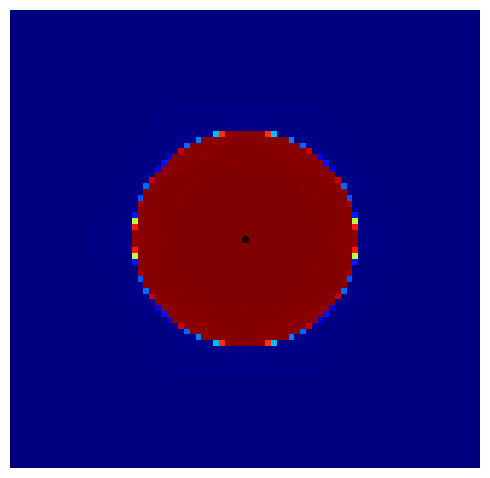

In [24]:
test.find_center()
print(test.ct)

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(test.original_pacbed, cmap="jet")
ax.axis("off")
ax.scatter(test.ct[1], test.ct[0], s=15, c="k")
fig.tight_layout()
plt.show()

radius of the BF disk = 19.11 mrad
radius of the RoI = 20.00 mrad
(53, 55, 41, 41)
[20, 20]


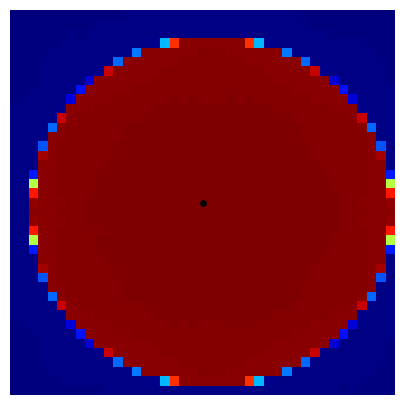

(41, 41)
19.105865034047014


In [26]:
test.disk_extract(buffer_size=1)
print(test.c_stack.shape)
print(test.c_ct)

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(test.c_pacbed, cmap="jet")
ax.scatter(test.c_ct[1], test.c_ct[0], s=15, c="k")
ax.axis("off")
plt.show()
print(test.c_pacbed.shape)
print(test.least_R)

[ 0.         19.10586503] [28.65879755 38.21173007]


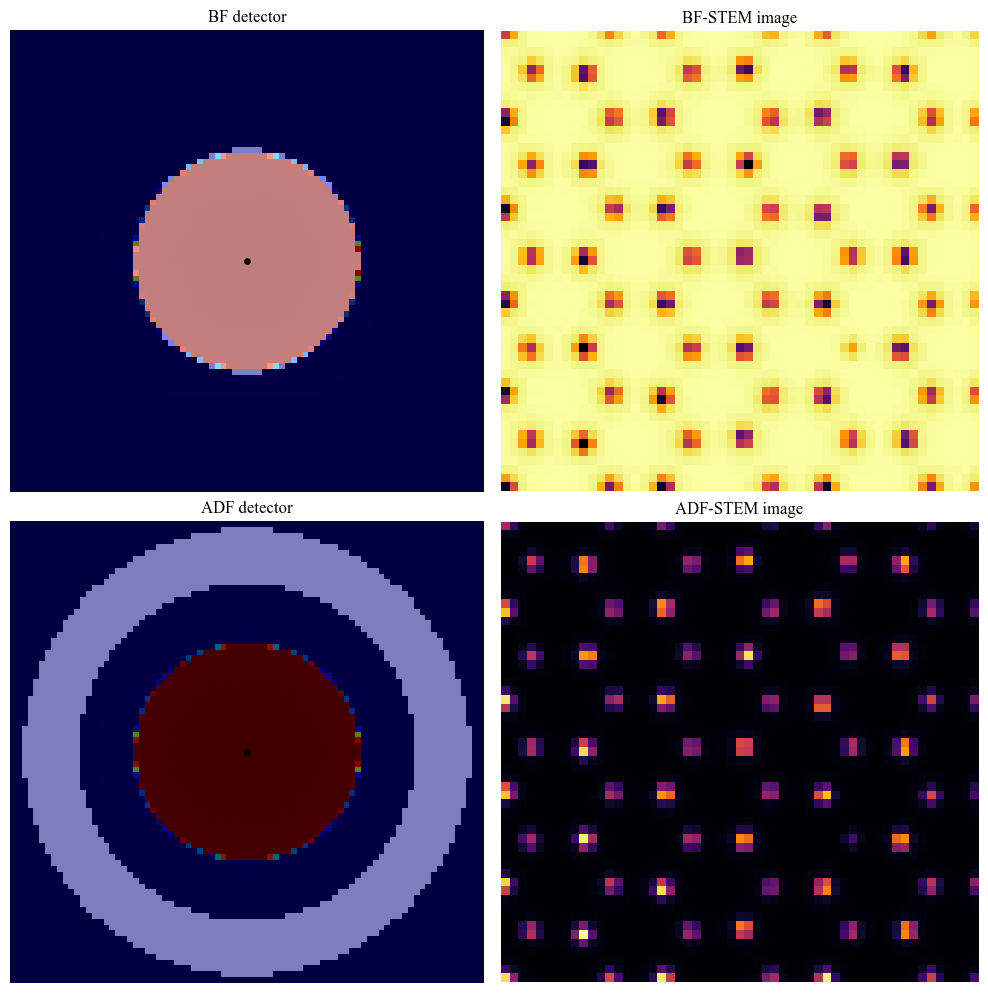

In [27]:
BF_det = np.array([0, test.least_R]) / mrad_per_pixel
ADF_det = np.array([1.5*test.least_R, 2.0*test.least_R]) / mrad_per_pixel

print(BF_det, ADF_det)

test.virtual_stem(BF_det, ADF_det)

fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0][0].imshow(test.original_pacbed, cmap="jet")
ax[0][0].imshow(test.BF_detector, cmap="gray", alpha=0.5)
ax[0][0].scatter(test.ct[1], test.ct[0], s=15, c="k")
ax[0][0].set_title("BF detector")
ax[0][0].axis("off")
ax[0][1].imshow(test.BF_stem, cmap="inferno", origin="lower")
ax[0][1].set_title("BF-STEM image")
ax[0][1].axis("off")
ax[1][0].imshow(test.original_pacbed, cmap="jet")
ax[1][0].imshow(test.ADF_detector, cmap="gray", alpha=0.5)
ax[1][0].scatter(test.ct[1], test.ct[0], s=15, c="k")
ax[1][0].set_title("ADF detector")
ax[1][0].axis("off")
ax[1][1].imshow(test.ADF_stem, cmap="inferno", origin="lower")
ax[1][1].set_title("ADF-STEM image")
ax[1][1].axis("off")
fig.tight_layout()
plt.show()

optimized angle = 0.9090909090909185


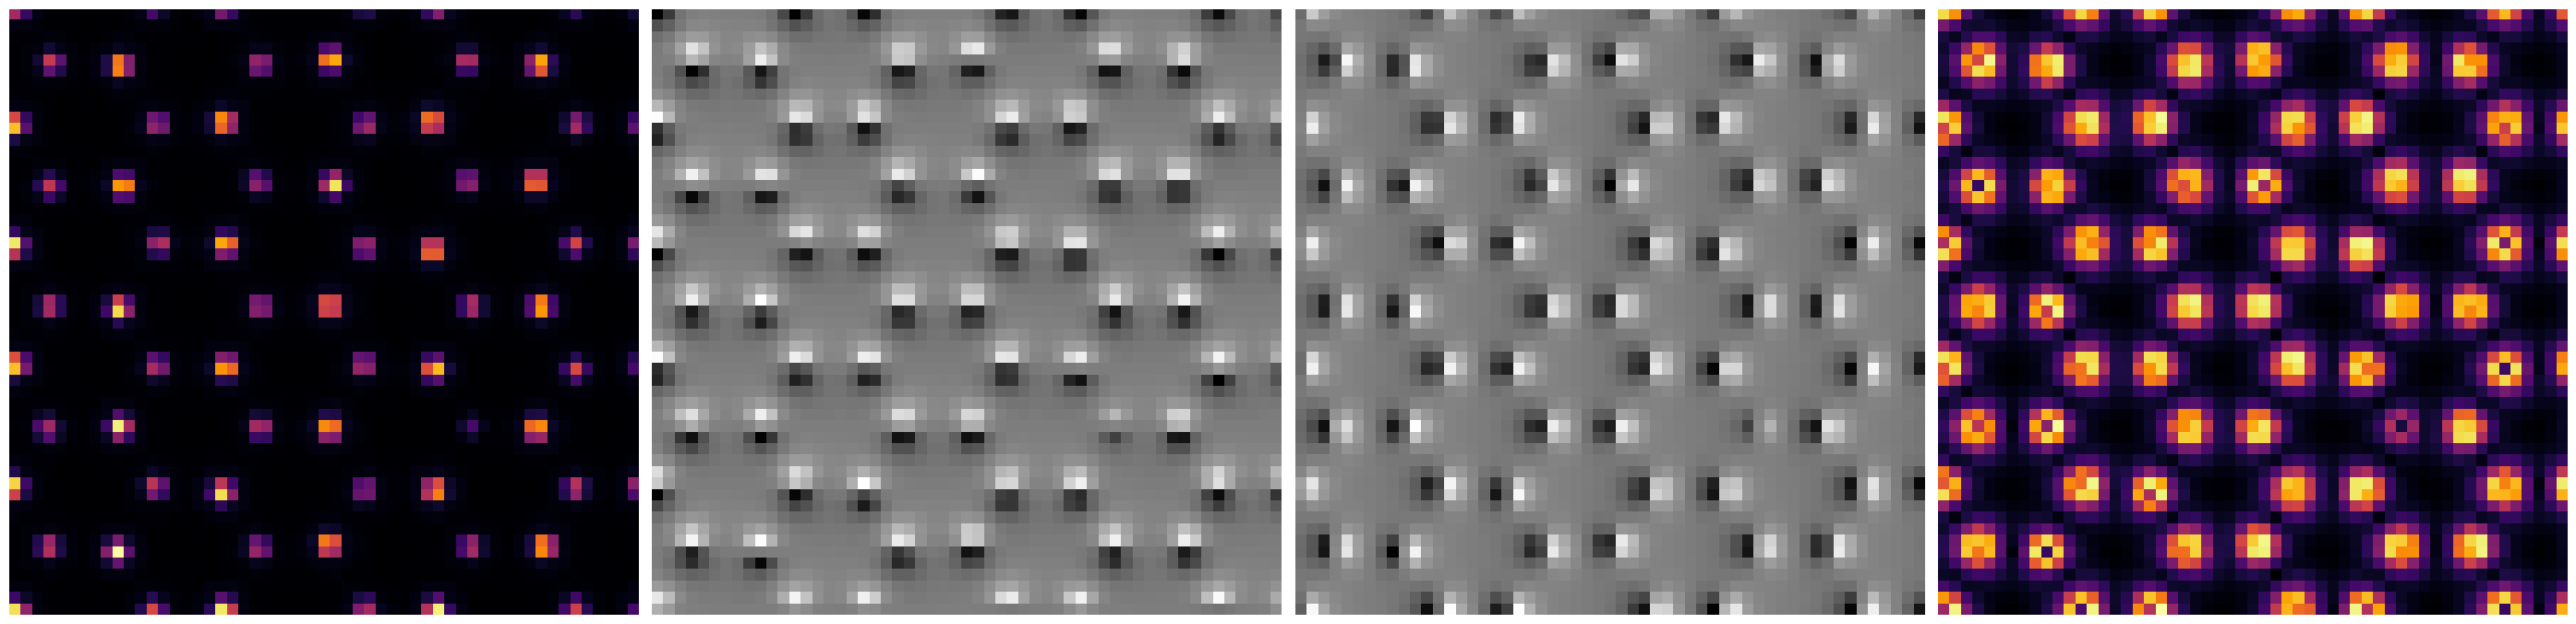

In [28]:
test.DPC(correct_rotation=True, n_theta=100, hpass=0.05, lpass=0.05)

print("optimized angle =", test.c_theta*180/np.pi)
fig, ax = plt.subplots(1, 4, figsize=(28, 7))
ax[0].imshow(test.ADF_stem, cmap="inferno", origin="lower")
ax[0].axis("off")
ax[1].imshow(test.E_field_y, cmap="gray", origin="lower")
ax[1].axis("off")
ax[2].imshow(test.E_field_x, cmap="gray", origin="lower")
ax[2].axis("off")
ax[3].imshow(test.E_mag, cmap="inferno", origin="lower")
ax[3].axis("off")
fig.tight_layout()
plt.show()

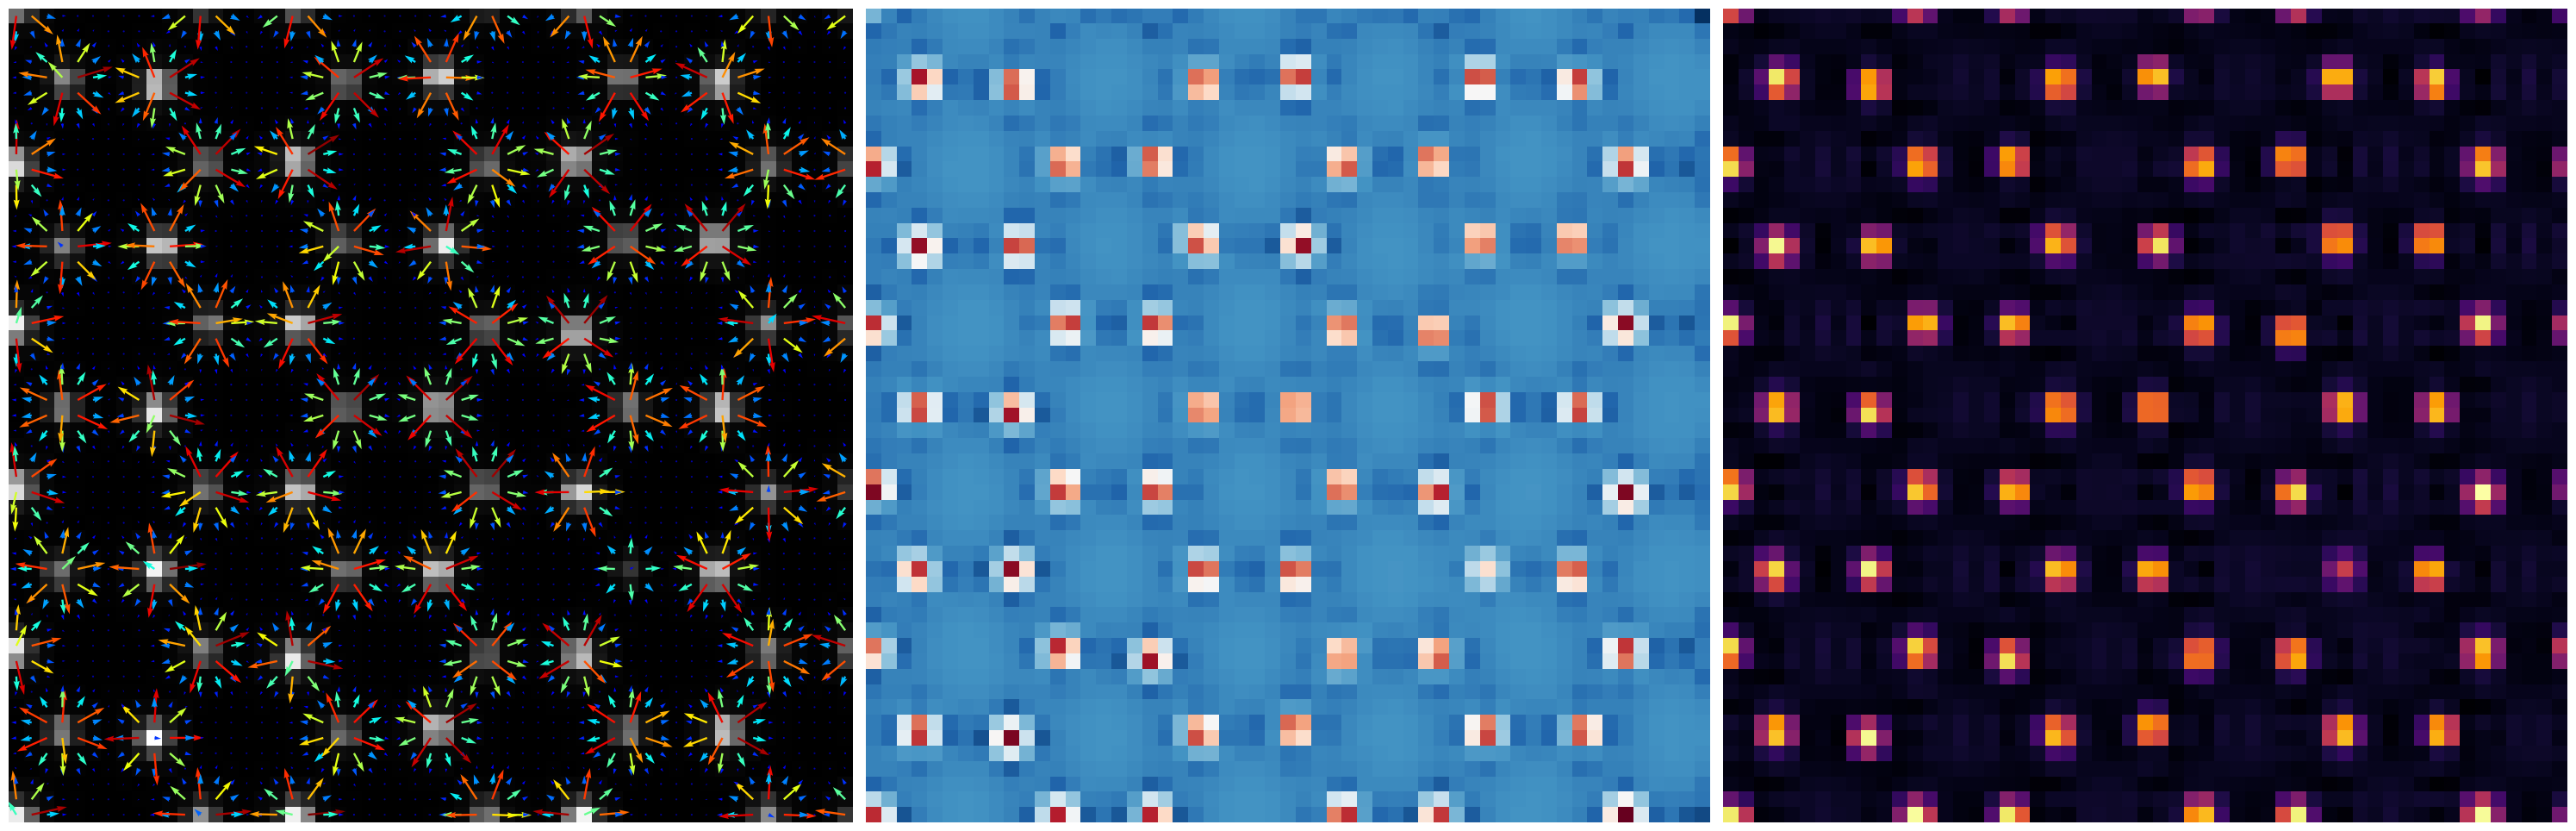

In [29]:
RY, RX = np.indices(test.c_shape[:2])

fig, ax = plt.subplots(1, 3, figsize=(30, 10))
ax[0].imshow(test.ADF_stem, cmap="gray", origin="lower")
ax[0].quiver(RX.flatten(), RY.flatten(), test.E_field_x.flatten(), test.E_field_y.flatten(), color=cm.jet(mcolors.Normalize()(test.E_mag.flatten())))
ax[0].axis("off")
#ax[1].imshow(test.ADF_stem, cmap="gray")
ax[1].imshow(test.charge_density, cmap="RdBu_r", origin="lower")
ax[1].axis("off")
#ax[2].imshow(test.ADF_stem, cmap="gray")
ax[2].imshow(test.potential, cmap="inferno", origin="lower")
ax[2].axis("off")
fig.tight_layout()
plt.show()

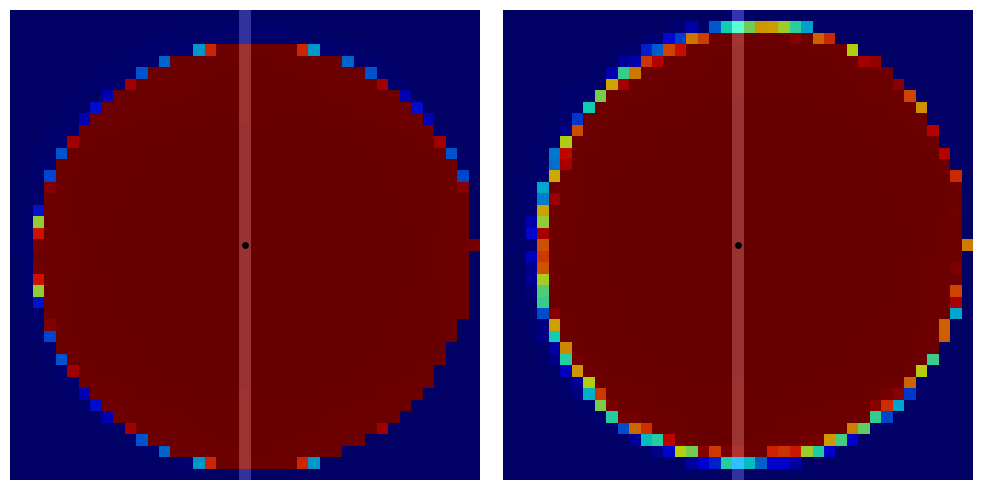

In [30]:
alpha, beta = np.cos(test.c_theta*180/np.pi), np.sin(test.c_theta*180/np.pi)
M = np.array([[alpha, beta, (1-alpha)*test.c_ct[1]-beta*test.c_ct[0]], 
              [-beta, alpha, beta*test.c_ct[1]+(1-alpha)*test.c_ct[0]]])

rotated_pacbed = rotation(test.c_pacbed, M)
ri = radial_indices(test.c_pacbed.shape, [0, test.cropped_size], 1, center=test.c_ct)
mirror_plane = np.zeros(rotated_pacbed.shape)
mirror_plane[:, int(test.c_ct[1])] = 1
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(np.multiply(test.c_pacbed, ri), cmap="jet")
ax[0].imshow(mirror_plane, cmap="gray", alpha=0.2)
ax[0].scatter(test.c_ct[1], test.c_ct[0], s=15, c="k")
ax[0].axis("off")
ax[1].imshow(np.multiply(rotated_pacbed, ri), cmap="jet")
ax[1].imshow(mirror_plane, cmap="gray", alpha=0.2)
ax[1].scatter(test.c_ct[1], test.c_ct[0], s=15, c="k")
ax[1].axis("off")
fig.tight_layout()
plt.show()

0 seconds have passed


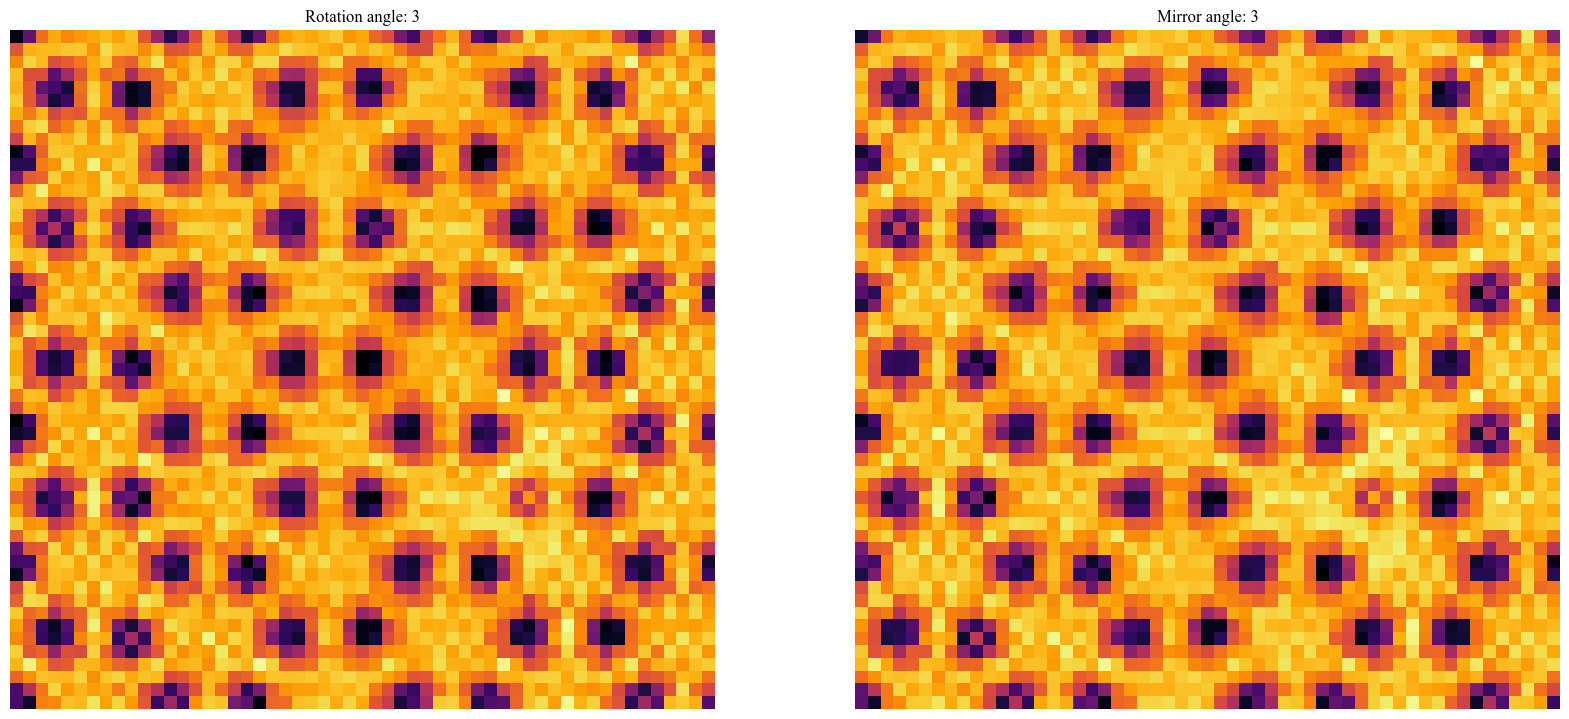

In [34]:
start = time.process_time()
rot_angle = 3
rotated_stack, rot_sym_img, mir_sym_img = test.symmetry_evaluation(rot_angle, also_mirror=True)
print("%d seconds have passed"%(time.process_time()-start))
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(rot_sym_img, cmap="inferno", origin="lower")
ax[0].set_title("Rotation angle: {}".format(rot_angle))
ax[0].axis("off")
ax[1].imshow(mir_sym_img, cmap="inferno", origin="lower")
ax[1].set_title("Mirror angle: {}".format(rot_angle))
ax[1].axis("off")
plt.show()

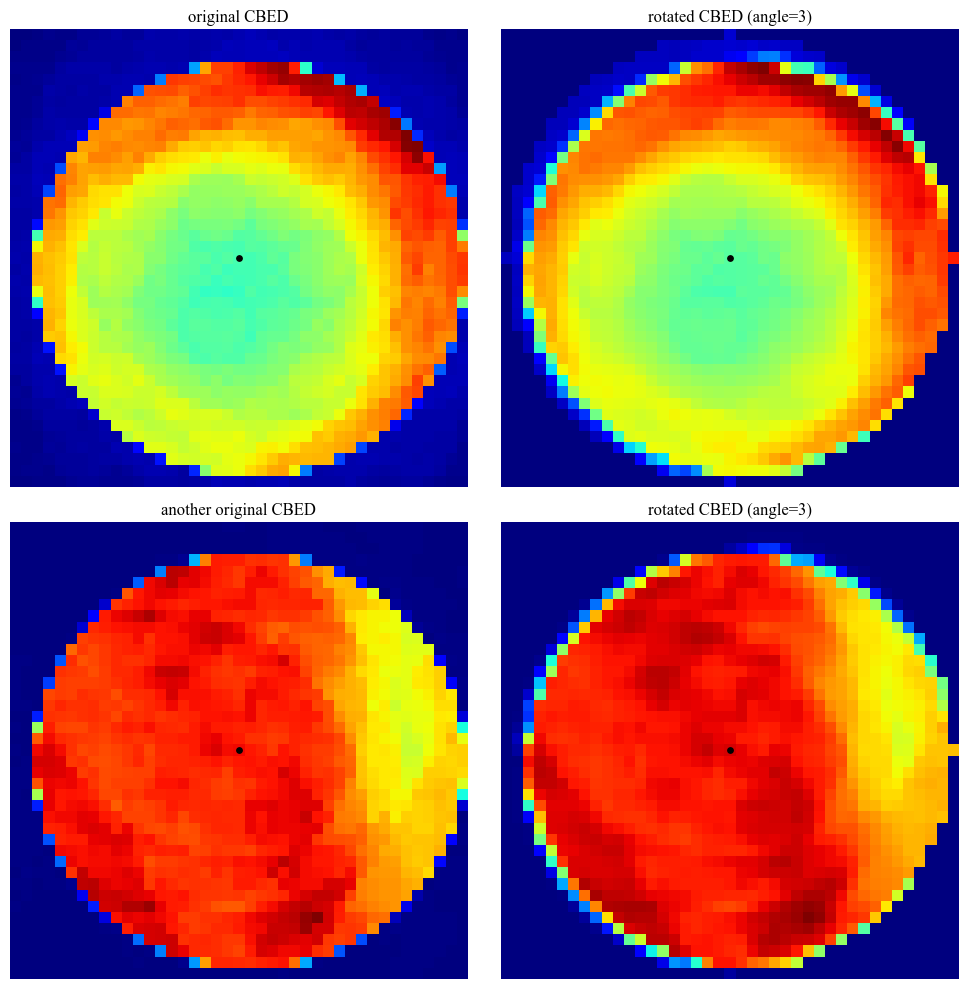

In [35]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0][0].imshow(test.c_stack[0, 0], cmap="jet")
ax[0][0].scatter(test.c_ct[1], test.c_ct[0], s=15, c="k")
ax[0][0].set_title("original CBED")
ax[0][0].axis("off")
ax[0][1].imshow(rotated_stack[0, 0], cmap="jet")
ax[0][1].scatter(test.c_ct[1], test.c_ct[0], s=15, c="k")
ax[0][1].set_title("rotated CBED (angle=%d)"%rot_angle)
ax[0][1].axis("off")
ax[1][0].imshow(test.c_stack[5, 5], cmap="jet")
ax[1][0].scatter(test.c_ct[1], test.c_ct[0], s=15, c="k")
ax[1][0].set_title("another original CBED")
ax[1][0].axis("off")
ax[1][1].imshow(rotated_stack[5, 5], cmap="jet")
ax[1][1].scatter(test.c_ct[1], test.c_ct[0], s=15, c="k")
ax[1][1].set_title("rotated CBED (angle=%d)"%rot_angle)
ax[1][1].axis("off")
fig.tight_layout()
plt.show()